In [1]:
# things we know and love
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier as sklearnRFClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
import os

#pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import RandomForestClassifier as sparkRFClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#findspark
import findspark
findspark.init()

### Initialize Spark Context and Session

In [2]:
sc = SparkContext()
spark = SparkSession(sc)

### Looking at the data

In [3]:
os.listdir('air_example')

['test.csv',
 'train-0.001m.csv',
 'train-0.01m.csv',
 'train-0.1m.csv',
 'train-1.0m.csv',
 'train-10.0m.csv',
 'valid.csv']

In [4]:
train_raw = spark.read.csv('air_example/train-0.001m.csv', header = True, inferSchema=True)
train_raw.show(10)

+-----+----------+---------+-------+-------------+------+----+--------+-----------------+
|Month|DayofMonth|DayOfWeek|DepTime|UniqueCarrier|Origin|Dest|Distance|dep_delayed_15min|
+-----+----------+---------+-------+-------------+------+----+--------+-----------------+
| c-10|      c-25|      c-3|    840|           B6|   IAD| BOS|     413|                N|
| c-12|      c-13|      c-3|    853|           UA|   LAX| KOA|    2504|                N|
|  c-9|       c-5|      c-2|   1541|           OH|   SAT| CVG|    1024|                N|
|  c-5|      c-12|      c-4|   1812|           F9|   DEN| LAX|     862|                Y|
|  c-5|      c-30|      c-2|   1028|           WN|   PIT| LAS|    1910|                N|
|  c-5|      c-31|      c-2|   2254|           OH|   CVG| DTW|     229|                N|
|  c-4|       c-8|      c-5|   1807|           XE|   IAD| EWR|     213|                Y|
|  c-1|      c-27|      c-5|   1608|           YV|   CLT| ROC|     573|                N|
|  c-6|   

In [5]:
train_raw.groupby('dep_delayed_15min').count().show()

+-----------------+-----+
|dep_delayed_15min|count|
+-----------------+-----+
|                Y|  219|
|                N|  781|
+-----------------+-----+



### Due to some Java/Python bug in this Docker container, for 100K+ datasets need to go through Pandas (#facepalm)

In [8]:
def get_data_spark_df(n=None):
    file_name = 'test' if n is None else 'train-' + str(n/1e6) + 'm'
    pd_df = pd.read_csv('air_example/' + file_name + '.csv', header = 0)
    spark_df = spark.createDataFrame(pd_df)
    return spark_df

In [9]:
train_raw = get_data_spark_df(1000)
train_raw.count()

1000

In [10]:
test_raw = get_data_spark_df()
test_raw.count()

100000

### Getting data ready for Random Forest

In [11]:
formula = RFormula(formula='dep_delayed_15min ~ .', featuresCol='features', labelCol='label')

In [12]:
def process_df_for_spark_rf(train, test):
    train_test = train.union(test)
    formula_fit = formula.fit(train_test)
    train_df = formula_fit.transform(train)
    test_df = formula_fit.transform(test)
    return train_df, test_df

In [13]:
train_df, test_df = process_df_for_spark_rf(train_raw, test_raw)

### Training Random Forest

In [15]:
def fit_spark_rf(train_df, test_df, n_trees=100):
    rf = sparkRFClassifier(numTrees=n_trees)
    rfModel = rf.fit(train_df)
    pred_df = rfModel.transform(test_df)    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction')
    auc = evaluator.evaluate(pred_df)
    return auc

In [16]:
auc = fit_spark_rf(train_df, test_df)
print('Test AUC for n = 1000: %.2f' % auc)

Test AUC for n = 1000: 0.62


### all together now, recording time

In [17]:
def sparkRF(n):
    train_raw = get_data_spark_df(n=n)
    train_df, test_df = process_df_for_spark_rf(train_raw, test_raw)
    start = time.time()
    auc = fit_spark_rf(train_df, test_df)
    end = time.time()
    return auc, end - start

In [18]:
sp_aucs = []
sp_times = []
ns =  [1e3, 1e4, 1e5, 1e6]
for n in ns:
    auc, t = sparkRF(n = n)
    sp_aucs.append(auc)
    sp_times.append(t)
    print('Finished with n %d' % n)

print(sp_aucs)
print(sp_times)

Finished with n 1000
Finished with n 10000
Finished with n 100000
Finished with n 1000000


KeyboardInterrupt: 

In [19]:
print(sp_aucs)
print(sp_times)

[0.6220709083931839, 0.6539690617742638, 0.6739095764673247, 0.6597432861800107]
[10.316120862960815, 14.830949306488037, 45.68885087966919, 191.07996010780334]


### Now Sklearn

In [20]:
def get_data_sklearn_df(n=None):
    file_name = 'test' if n is None else 'train-' + str(n/1e6) + 'm'
    pd_df = pd.read_csv('air_example/' + file_name + '.csv', header = 0)
    return pd_df

In [21]:
test_raw = get_data_sklearn_df()

In [22]:
def process_df_for_sklearn_rf(train, test):
    train_test = pd.concat([train, test])
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoder.fit(train_test.iloc[:, :8])
    X_train = encoder.transform(train.iloc[:, :8])
    X_test = encoder.transform(test.iloc[:, :8])
    y_train = train.iloc[:, 8]
    y_test = test.iloc[:, 8]
    return (X_train, y_train), (X_test, y_test)

In [23]:
def fit_sklearn_rf(X_train, y_train, X_test, y_test, n_trees=100):
    rf = sklearnRFClassifier(n_estimators=n_trees)
    rfModel = rf.fit(X_train, y_train)
    y_pred = rfModel.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [24]:
def sklearnRF(n):
    train_raw = get_data_sklearn_df(n=n)
    (X_train, y_train), (X_test, y_test) = process_df_for_sklearn_rf(train_raw, test_raw)
    start = time.time()
    auc = fit_sklearn_rf(X_train, y_train, X_test, y_test)
    end = time.time()
    return auc, end - start

In [25]:
sk_aucs = []
sk_times = []
ns =  [1e3, 1e4, 1e5]
for n in ns:
    auc, t = sklearnRF(n = n)
    sk_aucs.append(auc)
    sk_times.append(t)
    print('Finished with n %d' % n)

print(sk_aucs)
print(sk_times)

Finished with n 1000
Finished with n 10000
Finished with n 100000
[0.5322649965419047, 0.5825982172573585, 0.6213817356241749]
[6.6467859745025635, 29.57882595062256, 402.29898595809937]


### Stopped this after 1 hour...

In [22]:
# n = 1e6
# auc, t = sklearnRF(n = n)
# sk_aucs.append(auc)
# sk_times.append(t)
# print('Finished with n %d' % n)

In [23]:
ns =  [1e3, 1e4, 1e5, 1e6]
sk_aucs.append(sk_aucs[-1])
sk_times.append(3600)

### Let us compare

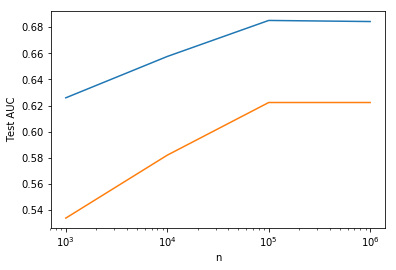

In [24]:
plt.plot(ns, sp_aucs, ns, sk_aucs)
plt.xlabel('n')
plt.ylabel('Test AUC')
plt.xscale('log')
plt.show()

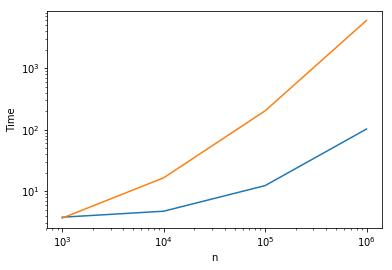

In [25]:
plt.plot(ns, sp_times, ns, sk_times)
plt.xlabel('n')
plt.ylabel('Time')
plt.xscale('log')
plt.yscale('log')
plt.show()